In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Enable inline plotting
%matplotlib inline

# Set style for all plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_city_data(base_folder, city, date):
    """Load and preprocess data for a specific city and date."""
    base_path = os.path.join(base_folder, city, date)
    
    # Load data files
    listings = pd.read_csv(f"{base_path}/listings.csv", low_memory=False)
    calendar = pd.read_csv(f"{base_path}/calendar.csv", low_memory=False)
    neighborhoods = pd.read_csv(f"{base_path}/neighbourhoods.csv")
    
    # Clean price columns
    listings['price_clean'] = listings['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['price_clean'] = calendar['price'].str.replace('$','').str.replace(',','').astype(float)
    calendar['date'] = pd.to_datetime(calendar['date'])
    
    return listings, calendar, neighborhoods

In [10]:
def print_basic_stats(listings, city, date):
    """Print basic statistics about the dataset."""
    print(f"\nBasic Statistics for {city.capitalize()} ({date}):")
    print("-" * 50)
    print(f"Number of listings: {len(listings):,}")
    print(f"Average price: ${listings['price_clean'].mean():.2f}")
    print(f"Median price: ${listings['price_clean'].median():.2f}")
    print(f"Number of neighborhoods: {listings['neighbourhood_cleansed'].nunique()}")
    print("-" * 50)

In [11]:
def plot_price_distributions(listings, city, date):
    """Plot price distribution visualizations."""
    plt.figure(figsize=(15, 5))
    price_data = listings['price_clean'][listings['price_clean'] <= listings['price_clean'].quantile(0.99)]
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=price_data, bins=50)
    plt.title('Price Distribution\n(≤99th percentile)')
    plt.xlabel('Price ($)')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=price_data, bins=50)
    plt.yscale('log')
    plt.title('Price Distribution (Log Scale)\n(≤99th percentile)')
    plt.xlabel('Price ($)')
    plt.suptitle(f'Price Distributions in {city.capitalize()} ({date})', y=1.05)
    plt.tight_layout()
    plt.show()

In [12]:
def plot_neighborhood_analysis(listings):
    """Plot neighborhood analysis visualizations."""
    plt.figure(figsize=(20, 15))
    neighborhood_stats = listings.groupby('neighbourhood_cleansed').agg({
        'id': 'count',
        'price_clean': 'mean',
        'review_scores_rating': 'mean'
    }).round(2).sort_values('id', ascending=True)
    
    plt.subplot(2, 2, 1)
    neighborhood_stats['id'].plot(kind='barh')
    plt.title('Number of Listings by Neighborhood')
    plt.xlabel('Number of Listings')
    
    plt.subplot(2, 2, 2)
    neighborhood_stats['price_clean'].plot(kind='barh')
    plt.title('Average Price by Neighborhood')
    plt.xlabel('Price ($)')
    
    plt.subplot(2, 2, 3)
    neighborhood_stats['review_scores_rating'].plot(kind='barh')
    plt.title('Average Rating by Neighborhood')
    plt.xlabel('Rating')
    
    plt.subplot(2, 2, 4)
    plt.scatter(neighborhood_stats['review_scores_rating'], 
               neighborhood_stats['price_clean'],
               alpha=0.6)
    plt.xlabel('Rating')
    plt.ylabel('Price ($)')
    plt.title('Price vs Rating by Neighborhood')
    plt.tight_layout()
    plt.show()

In [13]:
def plot_seasonal_patterns(calendar):
    """Plot seasonal pattern visualizations."""
    plt.figure(figsize=(20, 15))
    
    # Daily average prices
    plt.subplot(2, 2, 1)
    daily_avg = calendar.groupby('date')['price_clean'].mean()
    daily_avg.plot()
    plt.title('Daily Average Prices')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    
    # Monthly average prices
    plt.subplot(2, 2, 2)
    monthly_avg = calendar.groupby(calendar['date'].dt.month)['price_clean'].mean()
    monthly_avg.plot(kind='bar')
    plt.title('Monthly Average Prices')
    plt.xlabel('Month')
    plt.ylabel('Price ($)')
    
    # Day of week average prices
    plt.subplot(2, 2, 3)
    dow_avg = calendar.groupby(calendar['date'].dt.day_name())['price_clean'].mean()
    dow_avg.plot(kind='bar')
    plt.title('Average Prices by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    
    # Availability by month
    plt.subplot(2, 2, 4)
    calendar['available'] = calendar['available'].map({'t': 1, 'f': 0})
    monthly_availability = calendar.groupby(calendar['date'].dt.month)['available'].mean() * 100
    monthly_availability.plot(kind='bar')
    plt.title('Monthly Availability')
    plt.xlabel('Month')
    plt.ylabel('Availability (%)')
    plt.tight_layout()
    plt.show()

In [14]:
def plot_room_type_analysis(listings):
    """Plot room type analysis visualizations."""
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    listings['room_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Room Type Distribution')
    
    plt.subplot(2, 2, 2)
    sns.barplot(data=listings, x='room_type', y='price_clean')
    plt.title('Average Price by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 3)
    sns.barplot(data=listings, x='room_type', y='review_scores_rating')
    plt.title('Average Rating by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=listings, x='room_type', y='price_clean')
    plt.title('Price Distribution by Room Type')
    plt.xlabel('Room Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [15]:
def analyze_reviews_ratings(listings):
    """Plot review scores analysis."""
    plt.figure(figsize=(12, 8))
    review_cols = [col for col in listings.columns if col.startswith('review_scores_')]
    review_corr = listings[review_cols].corr()
    sns.heatmap(review_corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Review Scores')
    plt.tight_layout()
    plt.show()

In [16]:
def create_amenities_analysis(listings):
    """Plot amenities analysis if data is available."""
    if 'amenities' in listings.columns:
        # Process amenities
        try:
            listings['amenities_list'] = listings['amenities'].str.replace('"', '').str.replace("'", '"')
            listings['amenities_list'] = listings['amenities_list'].apply(eval)
        except:
            listings['amenities_list'] = listings['amenities'].str.strip('[]').str.split(',')
        
        listings['amenities_list'] = listings['amenities_list'].apply(
            lambda x: [item.strip().strip('"').strip("'") for item in x if item.strip()]
        )
        
        # Get top amenities
        all_amenities = []
        for amenity_list in listings['amenities_list']:
            all_amenities.extend(amenity_list)
        
        top_amenities = pd.Series(all_amenities).value_counts().head(20)
        
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 1, 1)
        sns.barplot(x=top_amenities.values, y=top_amenities.index)
        plt.title('Top 20 Most Common Amenities')
        plt.xlabel('Number of Listings')
        
        # Calculate price impact
        price_impact = []
        amenity_names = []
        
        for amenity in top_amenities.index:
            has_amenity = listings['amenities_list'].apply(lambda x: amenity in x)
            if has_amenity.any() and (~has_amenity).any():
                avg_with = listings[has_amenity]['price_clean'].mean()
                avg_without = listings[~has_amenity]['price_clean'].mean()
                price_impact.append(avg_with - avg_without)
                amenity_names.append(amenity)
        
        plt.subplot(2, 1, 2)
        sns.barplot(x=price_impact, y=amenity_names)
        plt.title('Price Premium for Each Amenity')
        plt.xlabel('Price Difference ($)')
        plt.tight_layout()
        plt.show()



Basic Statistics for Paris (2023-06-06):
--------------------------------------------------
Number of listings: 61,706
Average price: $198.02
Median price: $120.00
Number of neighborhoods: 20
--------------------------------------------------


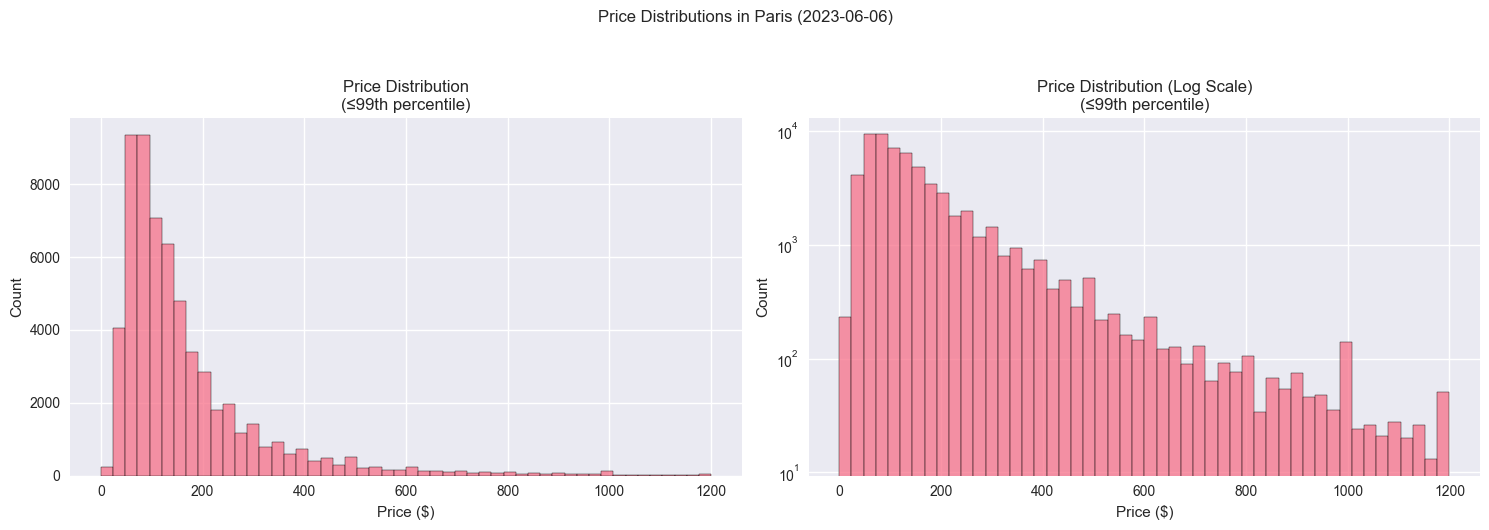

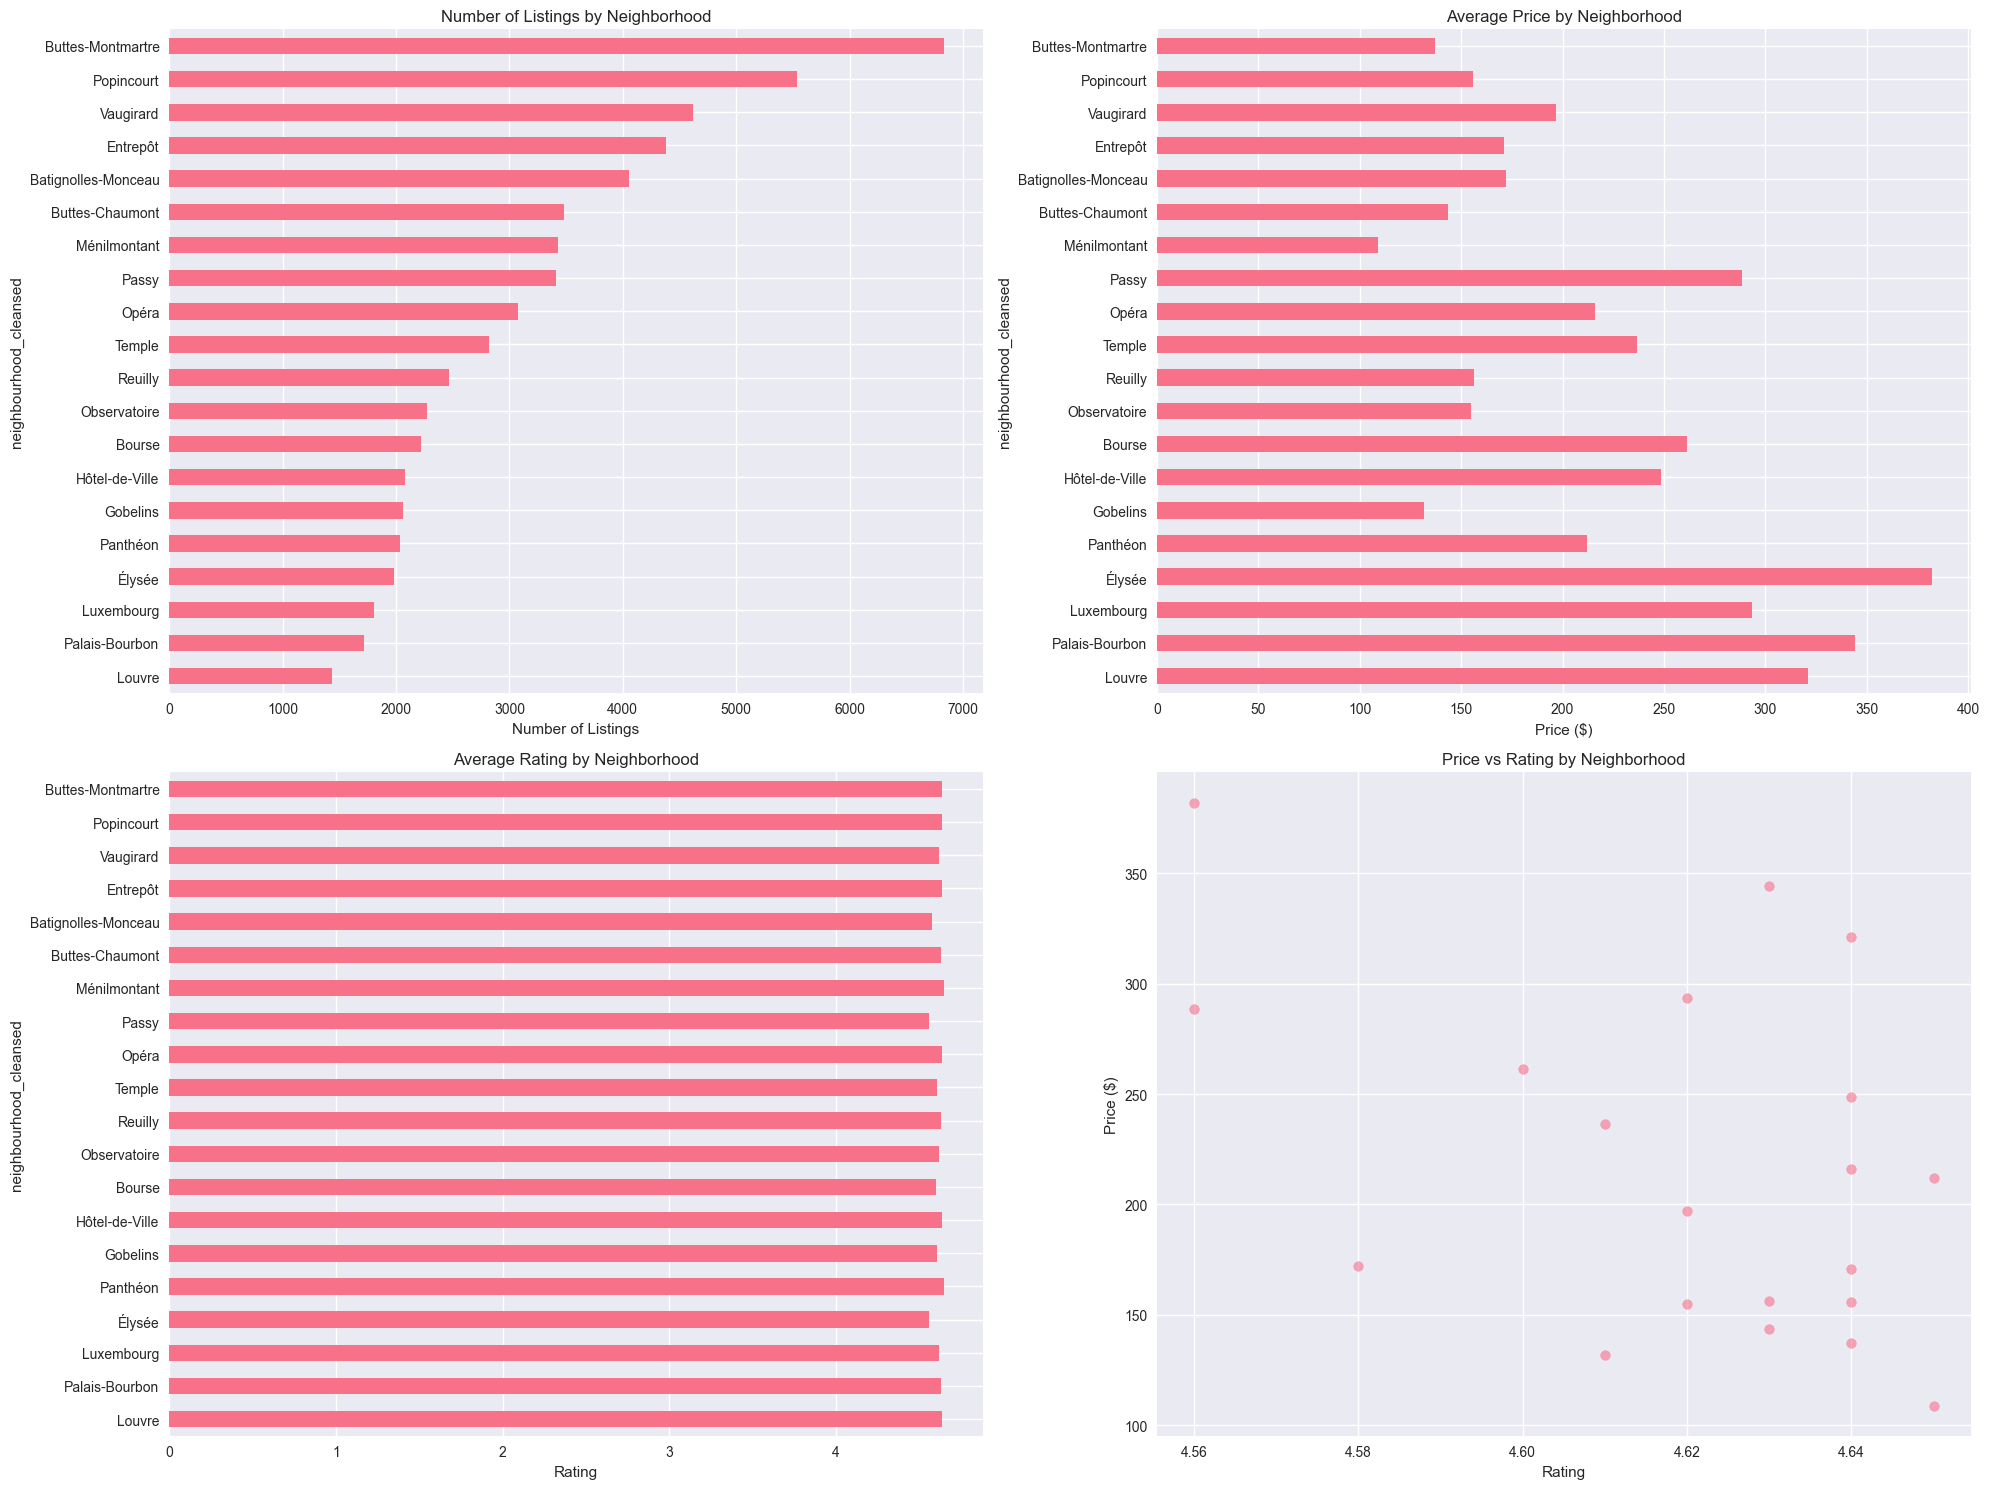

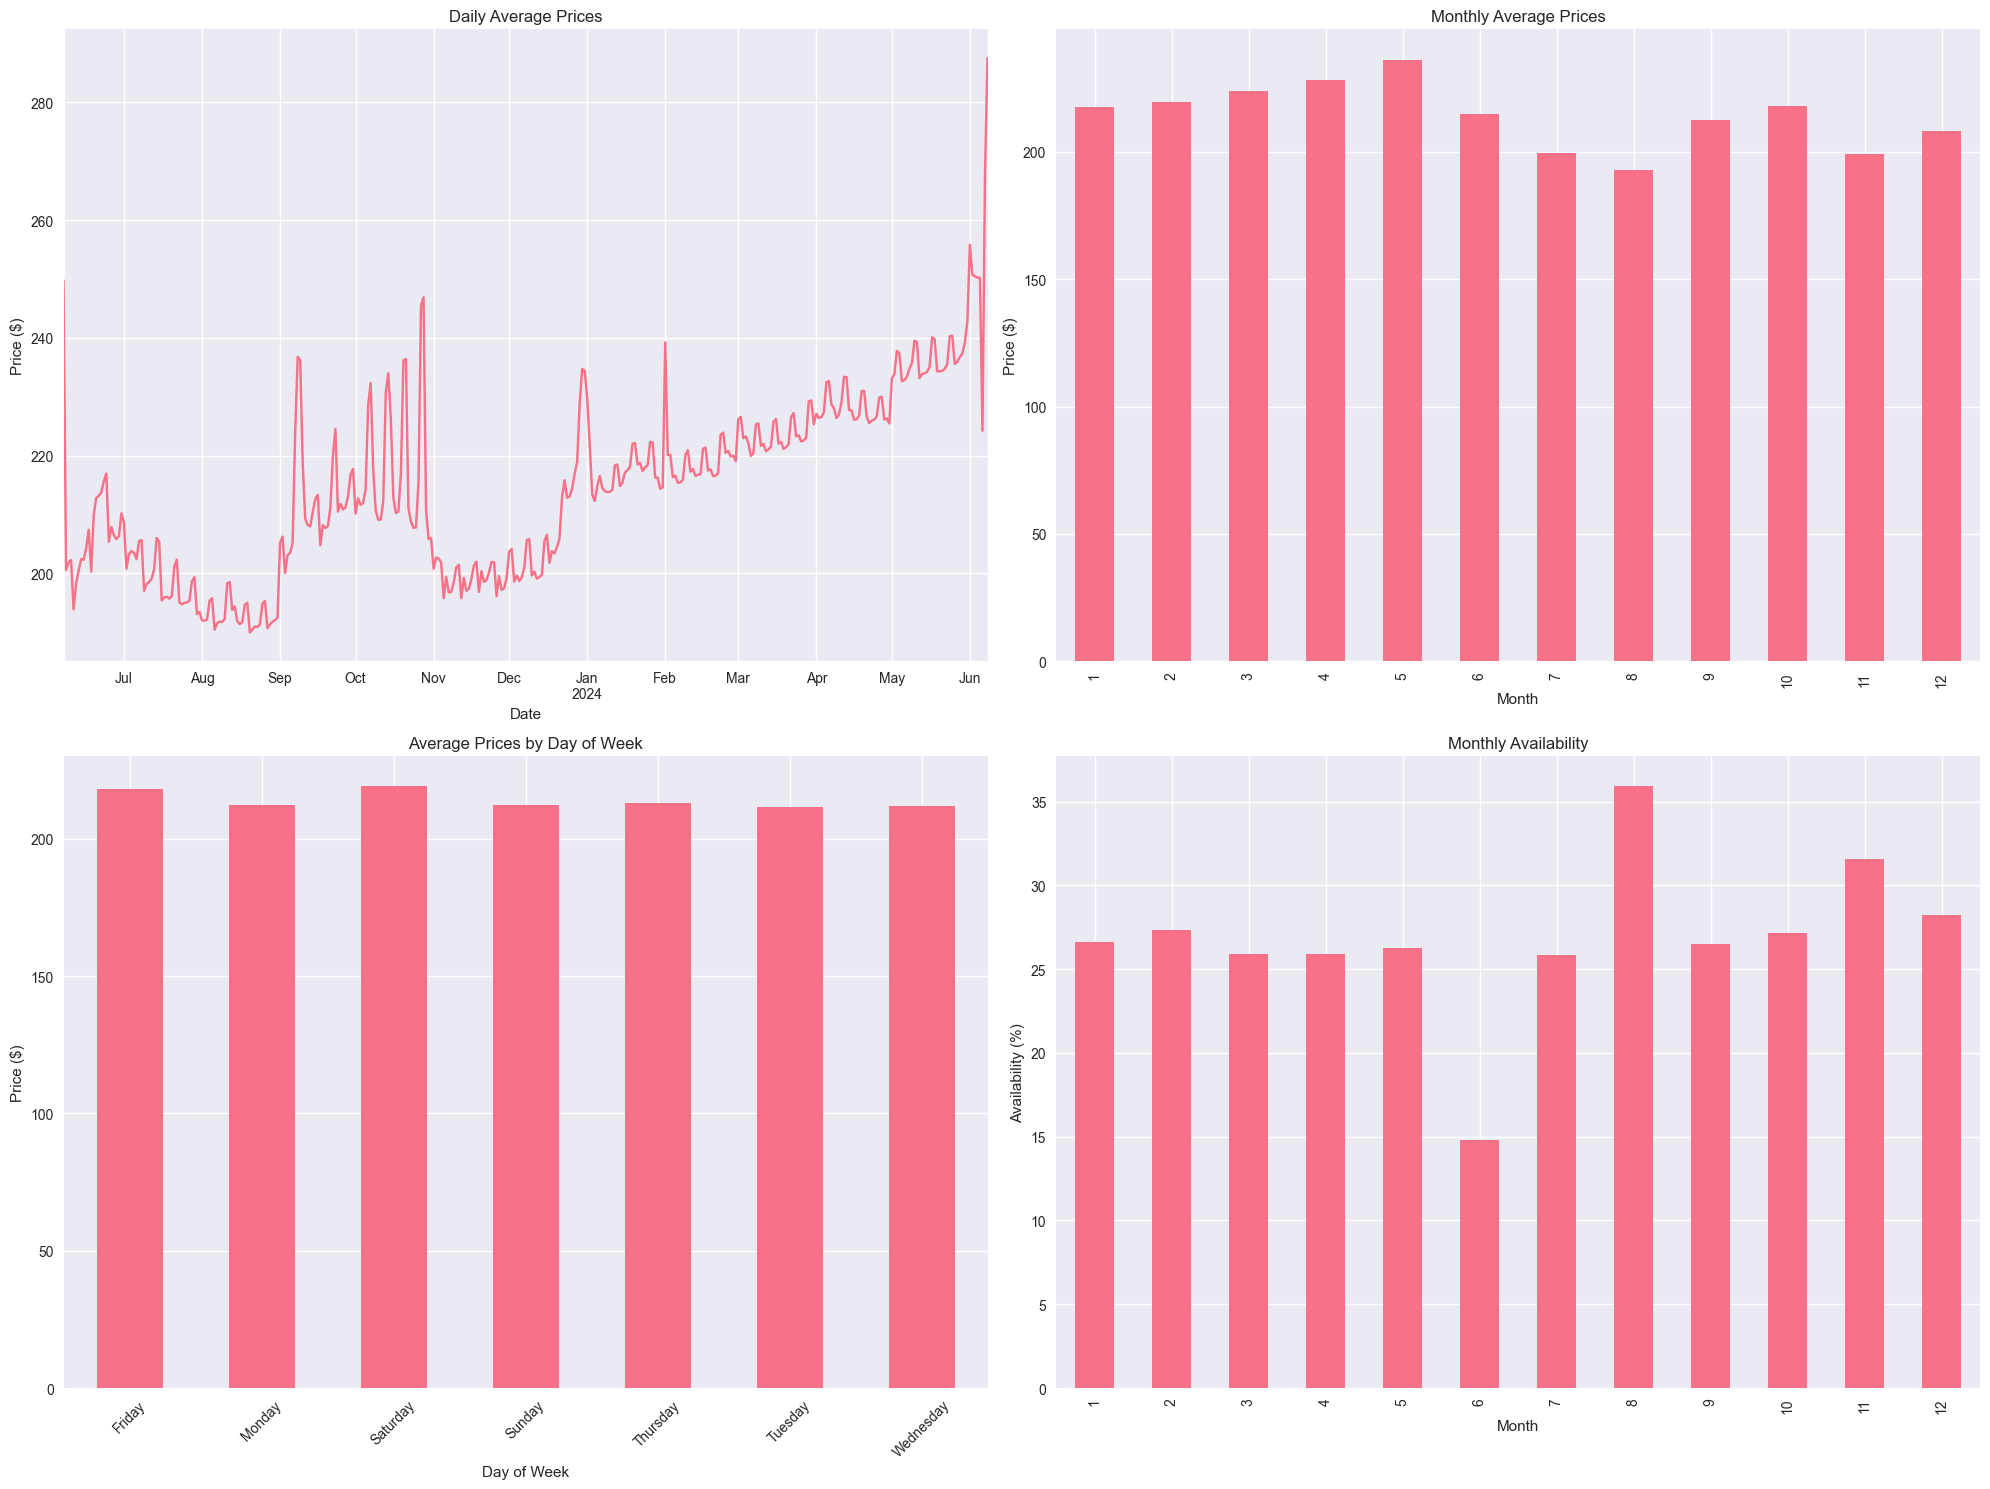

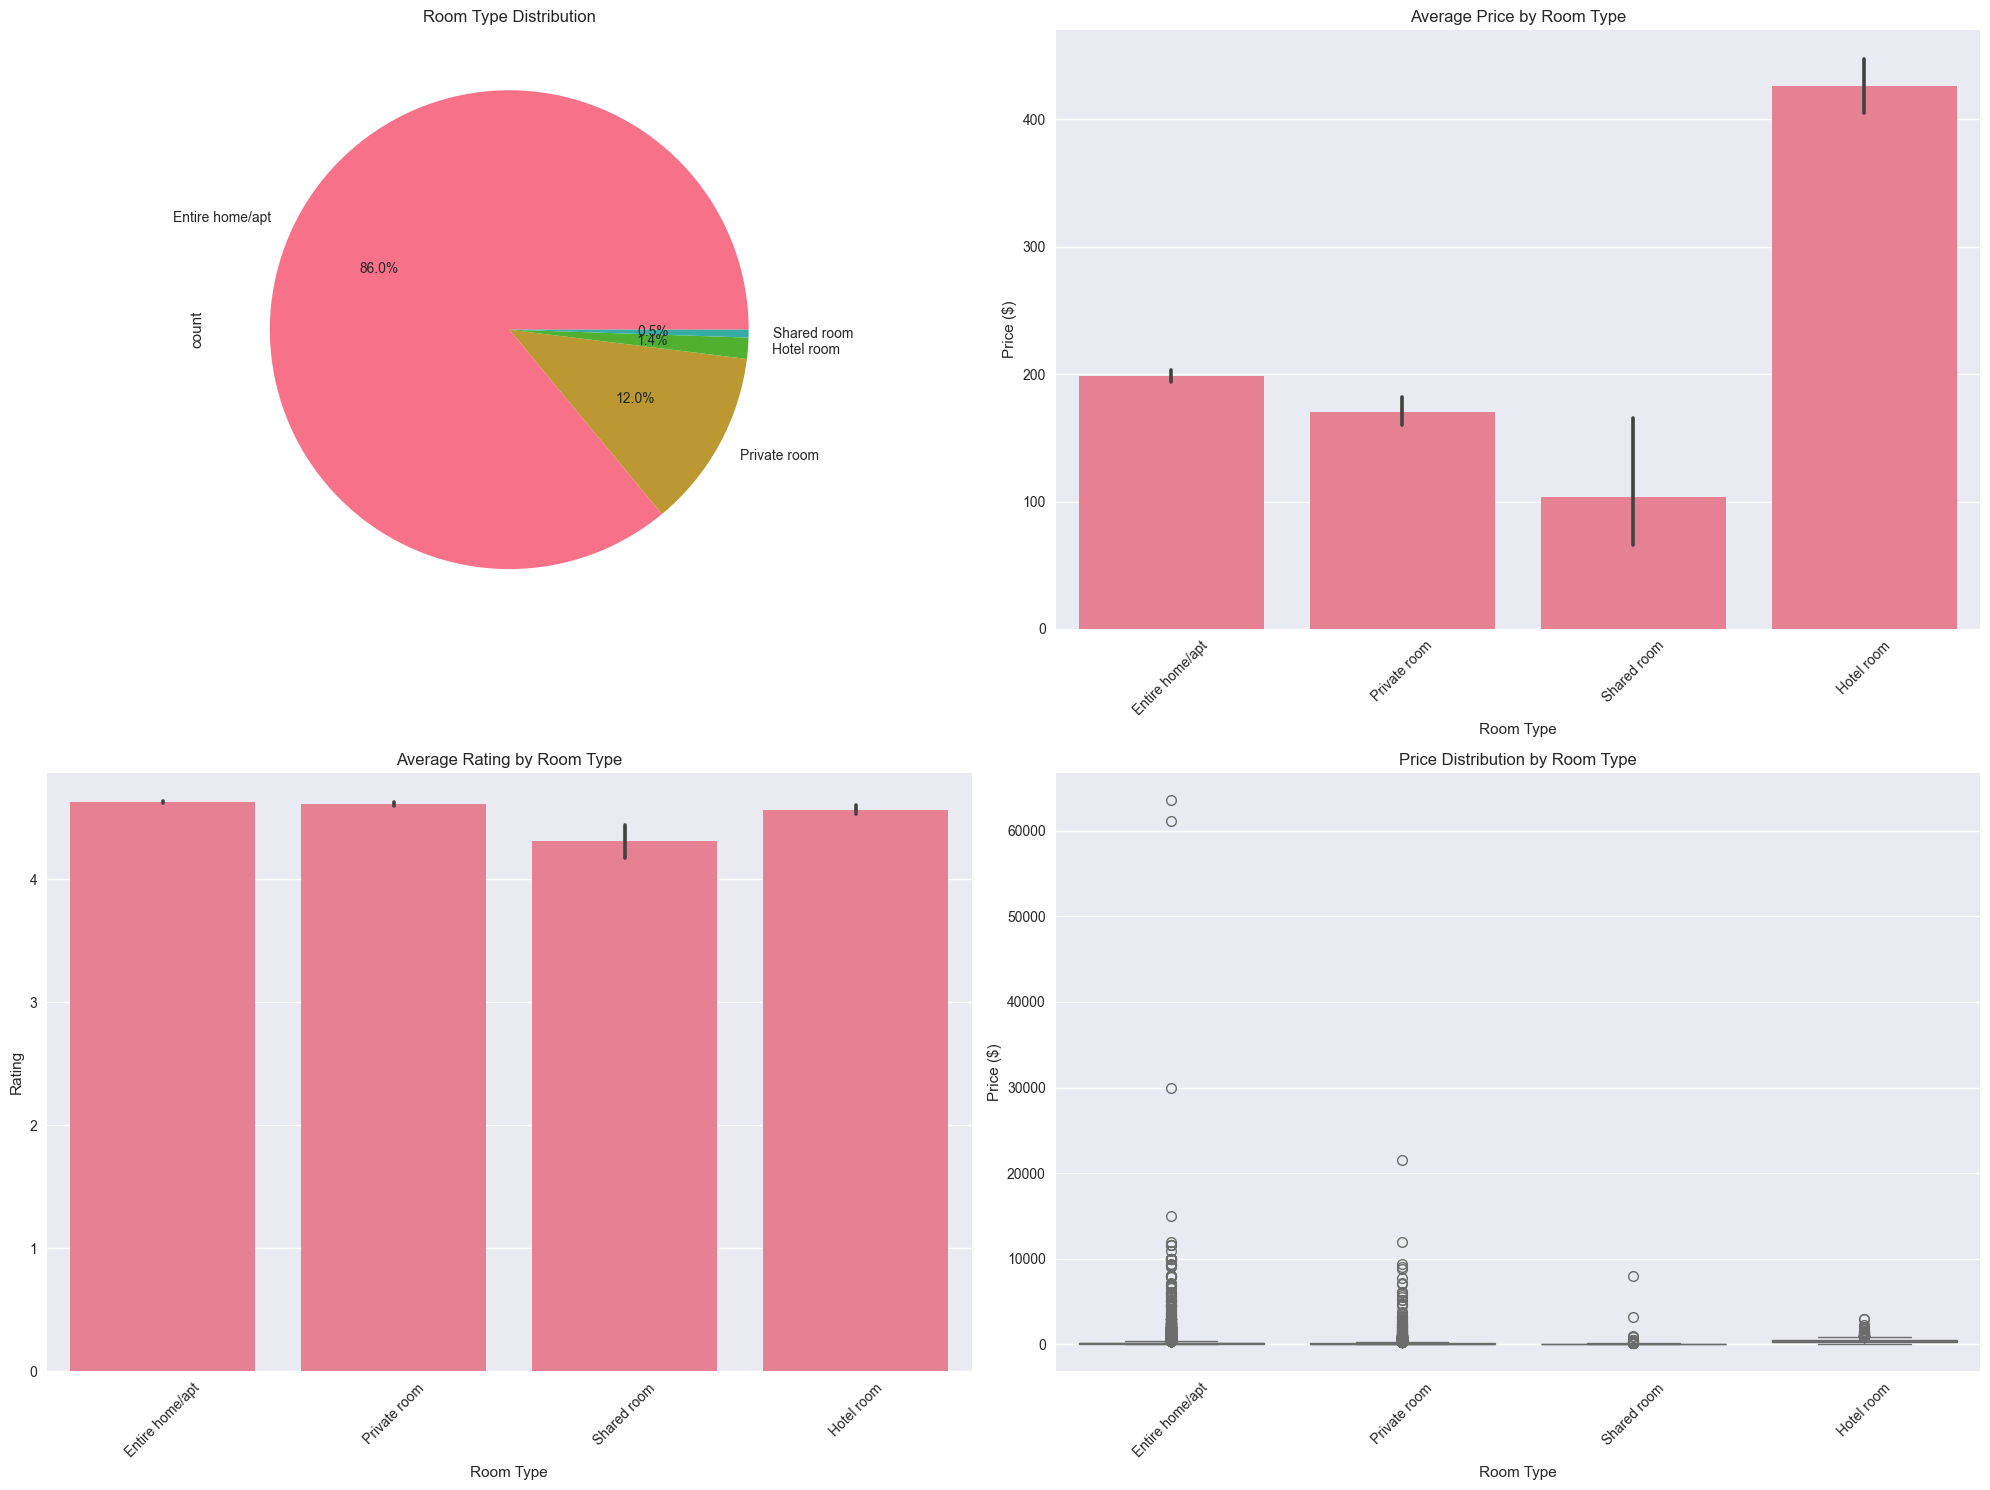

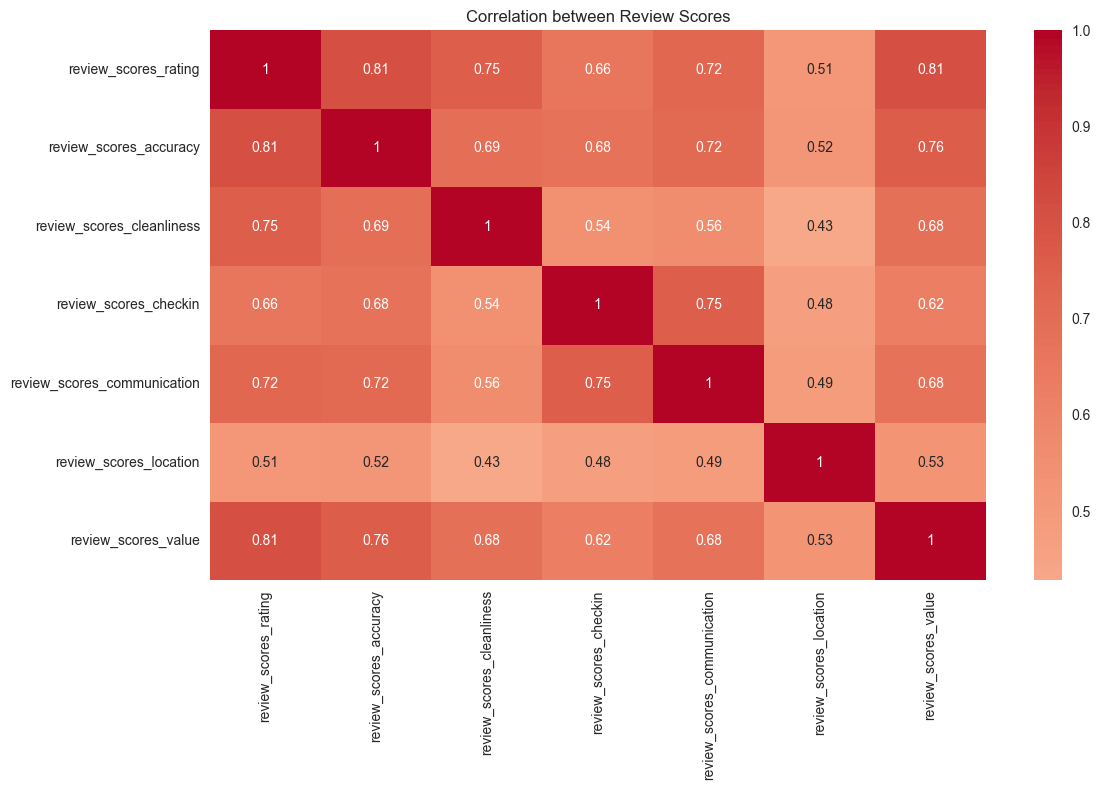

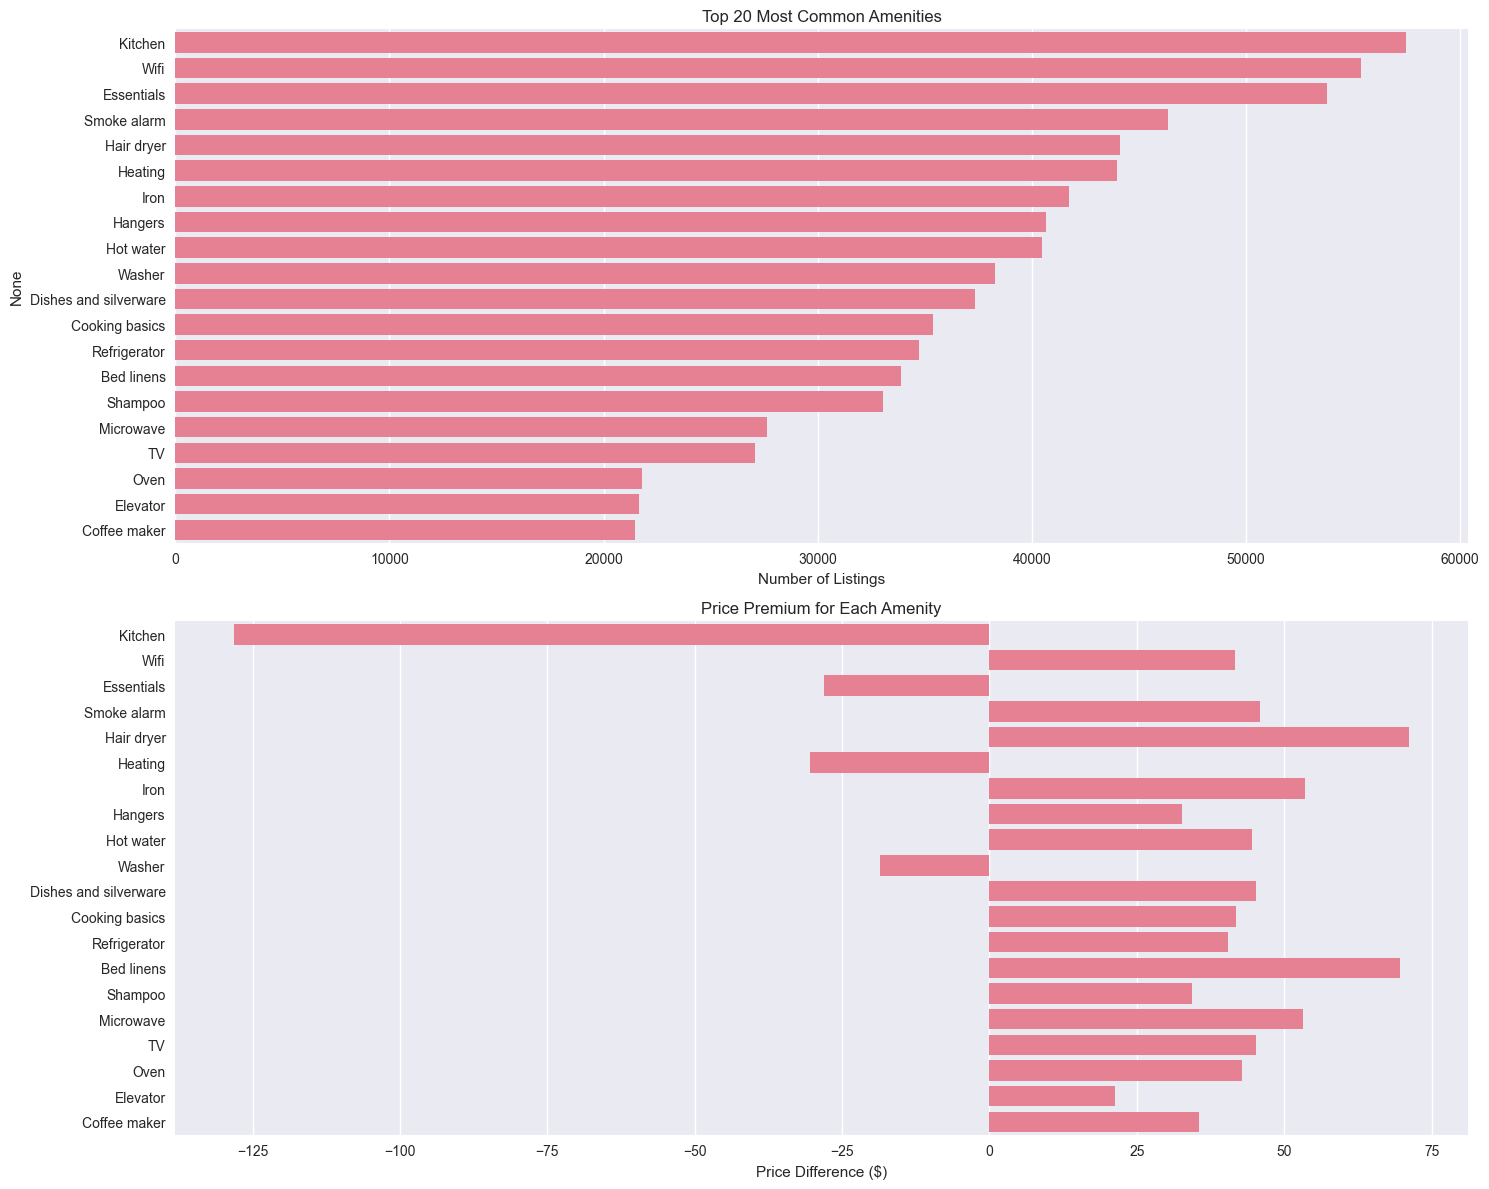

In [17]:
# Example usage - run this in a notebook cell:
base_folder = 'C:\\Users\\mvk\\Documents\\DATA_school\\thesis\\data_new'
city = "paris"
date = "2023-06-06"

# Load data
listings, calendar, neighborhoods = load_city_data(base_folder, city, date)

# Run analyses
print_basic_stats(listings, city, date)
plot_price_distributions(listings, city, date)
plot_neighborhood_analysis(listings)
plot_seasonal_patterns(calendar)
plot_room_type_analysis(listings)
analyze_reviews_ratings(listings)
create_amenities_analysis(listings)